<br>
<img src="https://images.even3.com.br/ONieRmTALZ2ETt2LfoUY4_IopIU=/fit-in/250x250/smart/even3.blob.core.windows.net/logos/UFCSPA-logotipo-1.19fc99573cf34163a727.png" style="width: 100px;"/>
<center>Diagnóstico por imagem
    <br>
    Professoras Carla Becker, Thatiane Alva e Viviane Botelho
    <br>
    Discente André Gonçalves Jardim</center>
    
# <center><font color='blue'>Redes Convolucionais</font></center>


In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import cv2
import time
import numpy as np
import keras as ke
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, GlobalAveragePooling2D
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from scipy.spatial.distance import pdist, squareform

%config Completer.use_jedi = False

import warnings
warnings.simplefilter("ignore")

## Importando as imagens

In [2]:
t1=time.time()
t2=time.time()



# Vetores de imagens e labels
image_data = []
label_data = []

TAMANHO_XY = 120

for filename in os.listdir('no/'):
    img = cv2.imread(os.path.join('no/',filename), cv2.IMREAD_GRAYSCALE)
    if img is not None:
        image_data.append(np.array(cv2.resize(img, (TAMANHO_XY, TAMANHO_XY), interpolation=cv2.INTER_AREA)))
        label_data.append(0)
        
for filename in os.listdir('yes/'):
    img = cv2.imread(os.path.join('yes/',filename), cv2.IMREAD_GRAYSCALE)
    if img is not None:
        image_data.append(np.array(cv2.resize(img, (TAMANHO_XY, TAMANHO_XY), interpolation=cv2.INTER_AREA)))
        label_data.append(1)

image_data = np.array(image_data)        
label_data = np.array(label_data)

print(f'Imagens: {image_data.shape})')
print(f'Numero de Labels: {len(label_data)}')

print("\ntempo de execução:"+str(round(time.time()-t1,2))+"s")

Imagens: (3000, 120, 120))
Numero de Labels: 3000

tempo de execução:3.36s


## Separando imagens em treitno, teste e validação

In [3]:
t1=time.time()

# dados -> treino/validação e teste
image_treino, image_teste,
label_treino, label_teste = train_test_split(image_data,
                                             label_data,
                                             test_size=0.1,
                                             random_state=13)

print("tempo de execução:"+str(round(time.time()-t1,2))+"s")

tempo de execução:0.02s


## Normalizando os dados e passando para one-hot encoding

In [1]:
t1=time.time()

#Redimensionando as imagens
image_treino = image_treino.reshape(2700, 120, 120, 1)
image_teste = image_teste.reshape(300, 120, 120, 1)


# Normalizar os dados
image_treino = image_treino.astype('float32')
image_teste = image_teste.astype('float32')

# Normalizar os dados
image_treino = image_treino/255.0
image_teste = image_teste/255.0

label_treino_one_hot = to_categorical(label_treino)
label_teste_one_hot = to_categorical(label_teste)


print(f'Imagens de treino : {image_treino.shape} \t Numero de Labels de treino: {len(label_treino)}')
print(f'Imagens de teste : {image_teste.shape} \t         Numero de Labels de teste: {len(label_teste)}')
print("\ntempo de execução:"+str(round(time.time()-t1,2))+"s")

NameError: name 'time' is not defined

# Representando as imagens

tempo de execução:0.03s


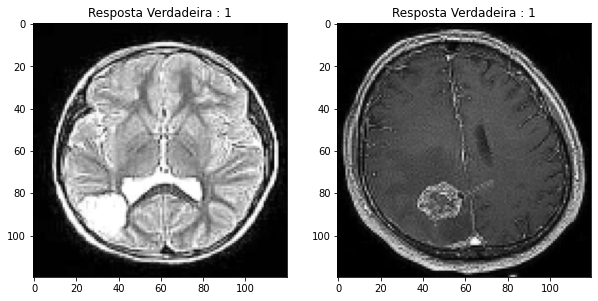

In [5]:
t1=time.time()

plt.figure(figsize=[10,10])

# Display na 1a imagem nos dados de treinamento:
plt.subplot(121)
plt.imshow(image_treino[0], cmap='gray')
plt.title("Resposta Verdadeira : {}".format(label_treino[0]))

# Display na 11a image dos dados de teste:
plt.subplot(122)
plt.imshow(image_teste[10], cmap='gray')
plt.title("Resposta Verdadeira : {}".format(label_teste[10]))

print("tempo de execução:"+str(round(time.time()-t1,2))+"s")

In [6]:
t1=time.time()

# FIXANDO UM PESSO ALEATÓRIO PARA COMEÇAR O APRENDIZADO
# # fixar o pseudo-random generator do tensorflow
tf.random.set_seed(10)

# CRIANDO A REDE
model = Sequential() 
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(TAMANHO_XY,TAMANHO_XY,1), padding='same'))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())

# CAMADAS
model.add(Dropout(0.4))
model.add(Dense(500, activation='relu'))  
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.summary()

print("tempo de execução:"+str(round(time.time()-t1,2))+"s")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 32)        0

In [7]:
t1=time.time()

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=3, shuffle=True)

fold_no = 1
for train, validation in kfold.split(image_treino, label_treino):
    
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history= model.fit(image_treino[train], # Dados de treino
                       label_treino[train], # Respostas de treino
                       batch_size=32, 
                       epochs=30, 
                       validation_data=(image_treino[validation], label_treino[validation]),# Dados de validação
                       verbose=False) 
    # Generate generalization metrics
    scores = model.evaluate(image_treino[validation], label_treino[validation], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Increase fold number
    fold_no = fold_no + 1

    
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

print("tempo de execução:"+str(round(time.time()-t1,2))+"s")

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.10466323047876358; accuracy of 97.00000286102295%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.023560166358947754; accuracy of 98.88888597488403%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.017539603635668755; accuracy of 99.33333396911621%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.10466323047876358 - Accuracy: 97.00000286102295%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.023560166358947754 - Accuracy: 98.88888597488403%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.0175396036

In [8]:
"""
t1=time.time()

# Compilando o modelo

adam = Adam(lr=0.0001)
model.compile(optimizer=adam, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("tempo de execução:"+str(round(time.time()-t1,2))+"s")
"""

'\nt1=time.time()\n\n# Compilando o modelo\n\nadam = Adam(lr=0.0001)\nmodel.compile(optimizer=adam, \n              loss=\'binary_crossentropy\',\n              metrics=[\'accuracy\'])\n\nprint("tempo de execução:"+str(round(time.time()-t1,2))+"s")\n'

In [9]:
"""
t1=time.time()

# Fixar estado de inicialização
history= model.fit(image_treino, # Dados de treino
                   label_treino, # Respostas de treino
                   batch_size=32, 
                   epochs=30, 
                   validation_data=(image_validacao, label_validacao),# Dados de validação
                   verbose=False) 

print("tempo de execução:"+str(round(time.time()-t1,2))+"s")
"""

'\nt1=time.time()\n\n# Fixar estado de inicialização\nhistory= model.fit(image_treino, # Dados de treino\n                   label_treino, # Respostas de treino\n                   batch_size=32, \n                   epochs=30, \n                   validation_data=(image_validacao, label_validacao),# Dados de validação\n                   verbose=False) \n\nprint("tempo de execução:"+str(round(time.time()-t1,2))+"s")\n'

# Curva de aprendizado

tempo de execução:0.06s


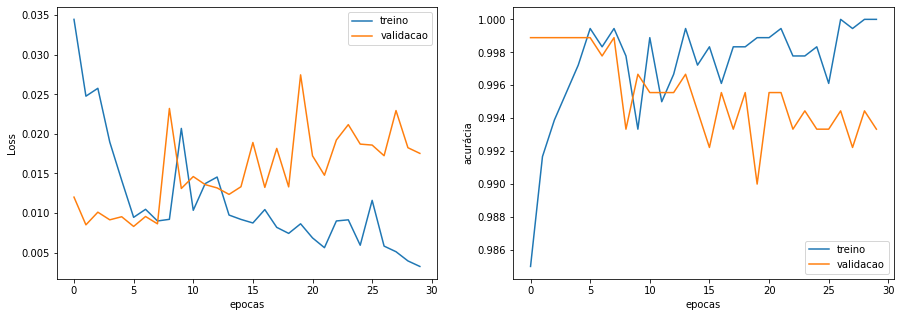

In [10]:
t1=time.time()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="treino")
plt.plot(history.history["val_loss"], label="validacao")
plt.xlabel("epocas")
plt.ylabel("Loss")
plt.legend();
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="treino")
plt.plot(history.history["val_accuracy"], label="validacao")
plt.xlabel("epocas")
plt.ylabel("acurácia") 
plt.legend();

print("tempo de execução:"+str(round(time.time()-t1,2))+"s")

### Relatório de classificação: TESTE DA REDE

In [11]:
t1=time.time()

predicted_classes = model.predict(image_teste)
predicted_classes = np.round(predicted_classes)

cmat = confusion_matrix(label_teste, predicted_classes)

cmat_df = pd.DataFrame(cmat,
                     index = ['0','1'], 
                     columns = ['0','1'])

target_names = ["Class {}".format(i) for i in range(2)]

print(classification_report(label_teste, predicted_classes, target_names=target_names))

# Definição das medidas de acurácia, sensibilidade e especificidade
acuracia = np.sum(np.diag(cmat))*100/np.sum(cmat)
sensibilidade = cmat_df.iloc[1][1]/(cmat_df.iloc[0][1]+cmat_df.iloc[1][1])*100
especificidade = cmat_df.iloc[0][0]/(cmat_df.iloc[1][0]+cmat_df.iloc[0][0])*100

print(f'Acurácia: {round(acuracia, 2)}%\nSensibilidade: {round(sensibilidade, 2)}%\nEspecificidade: {round(especificidade, 2)}%')

print("\nTempo de execução:"+str(round(time.time()-t1,2))+"s")

              precision    recall  f1-score   support

     Class 0       0.98      0.99      0.98       156
     Class 1       0.99      0.98      0.98       144

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300

Acurácia: 98.33%
Sensibilidade: 98.6%
Especificidade: 98.09%

Tempo de execução:0.75s


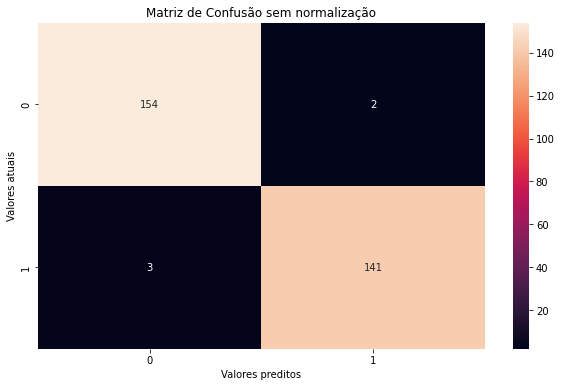


tempo de execução:0.22s
tempo de execução TOTAL:35.9min


In [12]:
t1=time.time()

#Plotando:
plt.figure(figsize=(10,6))
sns.heatmap(cmat_df, annot=True,fmt="d")
plt.title('Matriz de Confusão sem normalização')
plt.ylabel('Valores atuais')
plt.xlabel('Valores preditos')
plt.show()

print("\ntempo de execução:"+str(round(time.time()-t1,2))+"s")
print("tempo de execução TOTAL:"+str(round((time.time()-t2)/60,2))+"min")